## Part 4: Network analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from utils.functions import truncate

In [2]:
sfw_matrix = pd.read_pickle('results/sfw_matrix.pickle')
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')
G = nx.read_gpickle('results/G.pickle')

In [3]:
# Strongly connected: no
# Density: 0.17029
# find diameter

### 4.1 Network chracteristics (complexity, connectance, connectedness)

Complexity as the average number of links per species (*Christian needs to confirm and which one to use?)

In [4]:
# Complexity (average number of links per species (Wikipedia())
from statistics import mean
def complexity(g):
    """Calculates the average number of edges (degree) per node in a graph g"""
    deg = g.degree()
    deg_ls = []
    for n, d in deg:
        deg_ls.append(d)
    
    return mean(deg_ls) 

# Connectance
connectance = G.number_of_edges() / (G.number_of_nodes())**2

print(f"Complexity: {complexity(G)}")
print(f"Connectance: {connectance}") 

Complexity: 7.833333333333333
Connectance: 0.16319444444444445


In [5]:
# connectedness (edge and node)
nx.edge_connectivity(G)

0

#### 4.1.# Degree distribution

Degree distribution summarizes the graph in a way which indicates its structure, e.g., homogeneous structure vs. singletons and hubs.

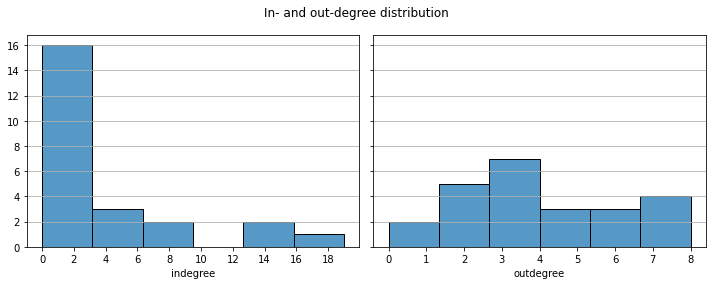

In [6]:
degrees = pd.DataFrame({'node': [x[0] for x in G.in_degree()],
                        'indegree': [x[1] for x in G.in_degree()],
                        'outdegree': [x[1] for x in G.out_degree()]
                       })
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey='row')
fig.suptitle('In- and out-degree distribution')
sns.histplot(data=degrees, x='indegree', ax=ax1)
ax1.set_xticks(np.arange(0,20,2))
ax1.grid(which='major', axis='y')
ax1.set(ylabel=None)

sns.histplot(data=degrees, x='outdegree', ax=ax2)
ax2.grid(which='major', axis='y')
fig.tight_layout()

### 4.2 Identyfing key nodes and edges

#### 4.2.1 Degree ratio
The degree ratio [1] assigns to every node in a digraph its outdegree divided by its indegree. To avoid dividing by zero, 1 is added to both the out- as well as indegree of every node. This measeure is similar to the Copeland score but can give different results in some situations.

_René van den Brink, Agnieszka Rusinowska, The degree ratio ranking method for directed graphs, European Journal of Operational Research, Volume 288, Issue 2, 2021, Pages 563-575._

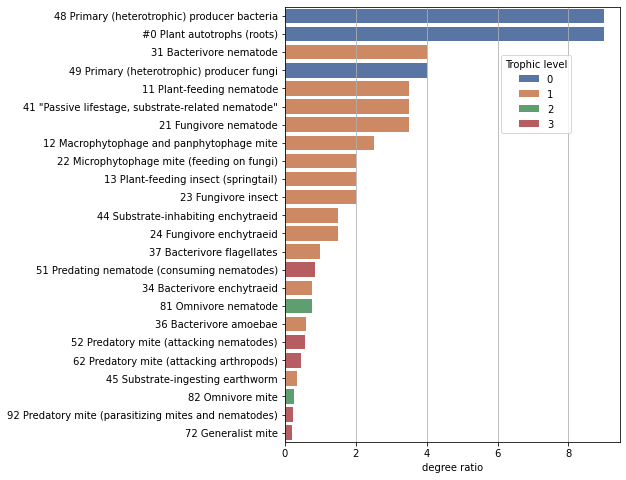

In [7]:
degrees['degree ratio'] = (degrees['outdegree'] + 1) / (degrees['indegree'] + 1)
degrees['trophic level'] = [trophic_levels.to_dict()[node] for node in G.nodes]

fig, plot = plt.subplots(figsize=(6, 8))
# sns.set(font_scale = 1.4)
ax = sns.barplot(x="degree ratio", y="node", hue='trophic level', 
                 data=degrees.sort_values(by='degree ratio', ascending=False), 
                 dodge=False, palette='deep')
ax.set(ylabel=None)
ax.grid(which='major', axis='x')
_ = ax.legend(loc='upper center', title='Trophic level',  bbox_to_anchor=(0.75, 0.90)) #,  fontsize=10)
# _ = ax.set_title('Node degree ratio')
plt.savefig('results/degree_ratio.png', bbox_inches='tight')

#### 4.2.3 Node centrality measures

Centrality is one of the measures of the importance of a node in the graph. Here we compute some of the most typical centrality measures and plot them together for a better comparison.

In [8]:
from utils.ui_functions import make_download_button

df_measures = pd.DataFrame.from_dict({"out-degree centrality": nx.out_degree_centrality(G),
                                      "in-degree centrality": nx.in_degree_centrality(G),
                                      "betweenness centrality": nx.betweenness_centrality(G),
                                      "closeness centrality": nx.closeness_centrality(G),
                                     "eigenvector centrality": nx.eigenvector_centrality(G)})
df_measures.index.name = 'trophic group'
display(make_download_button('centrality_measures.csv', raw_contents=df_measures.to_csv()))

HTML(value='<html>\n<head>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n</head>\n<bo…

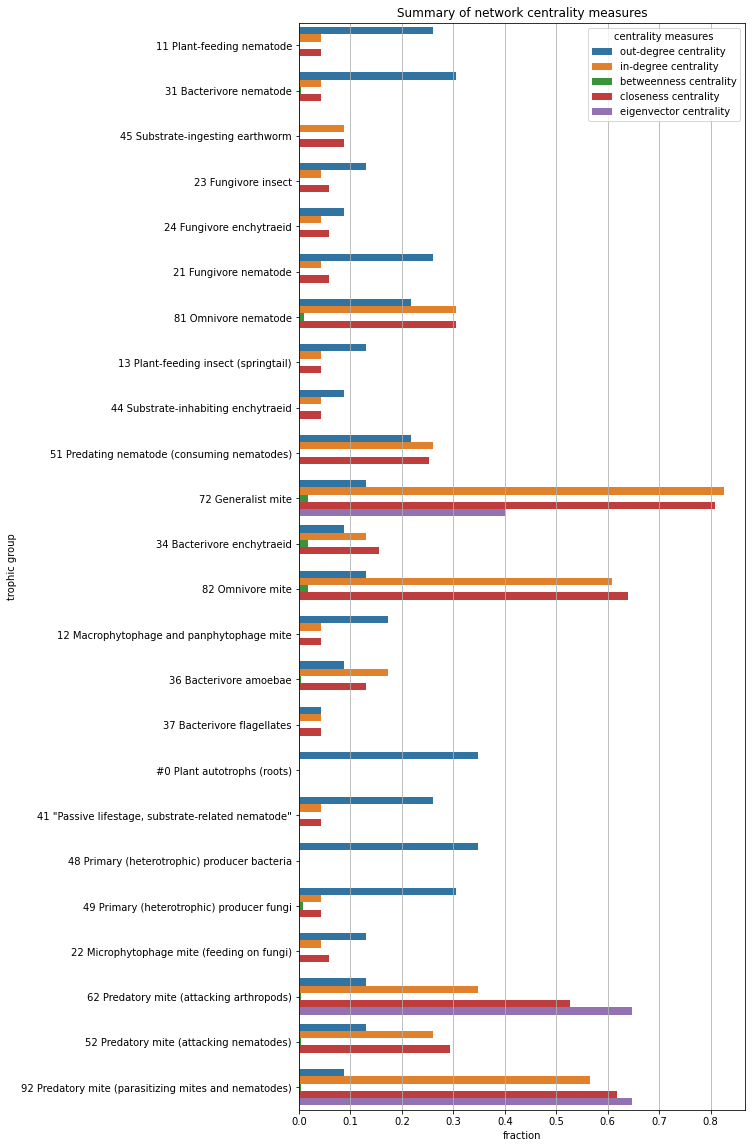

In [9]:
# to long format
df_meassures_melt = df_measures.reset_index()
df_meassures_melt = df_meassures_melt.melt("trophic group", var_name='centrality measures', value_name='fraction')

fig, plot = plt.subplots(figsize=(8, 20))
ax = sns.barplot(x="fraction", y="trophic group", hue='centrality measures', data=df_meassures_melt)
ax.grid(which='major', axis='x')
_ = ax.set_title("Summary of network centrality measures")

# ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# ax.set_yticks(np.arange(0,1.1,0.1))
# _ = ax.set_ylim(0,1)
# _ = ax.set_xticklabels([truncate(s, 25) for s in df_measures.index])

In [10]:
# rank above by in-degree, take first 10 only

#### 4.2.4 Edge centrality measures

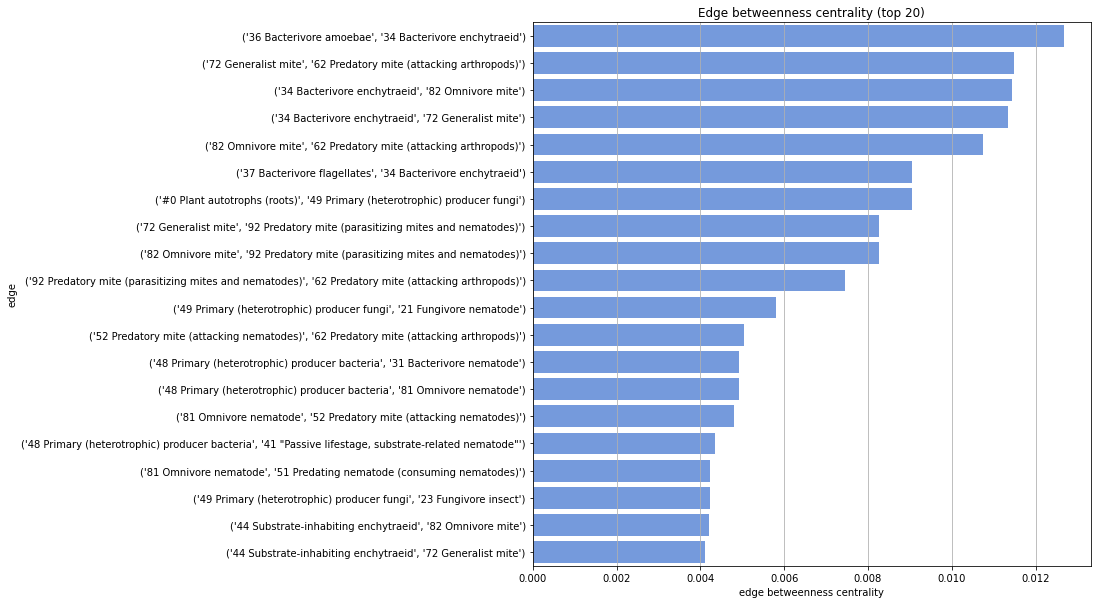

In [11]:
edge_centralities = pd.DataFrame(sorted(nx.centrality.edge_betweenness_centrality(G).items(), reverse=True, key=lambda x: x[1]), 
                                 columns=['edge', 'edge betweenness centrality'])

fig, plot = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x='edge betweenness centrality', y='edge', data=edge_centralities.iloc[:20], color='cornflowerblue')
ax.grid(which='major', axis='x')
_ = ax.set_title('Edge betweenness centrality (top 20)')

## Compartment analysis

### Reciprocal realtionships

In [12]:
# TO-DO: find reciprocal link
set([1,2]) - {1}

{2}

### Transitive triangles

Here we compute triangle motifs which are also transitive. Since the network may include loops and reciprocal edges, filtering is required in the edge-iterator algorithm [1] to ignore false positives. It is also worth noting that if reciprocal edges exist cyclic triangles can become transitive.

[1] Schank T., Wagner D. (2005) Finding, Counting and Listing All Triangles in Large Graphs, an Experimental Study. In: Nikoletseas S.E. (eds) Experimental and Efficient Algorithms. WEA 2005. Lecture Notes in Computer Science, vol 3503. Springer, Berlin, Heidelberg.

Transitive triangles: 122


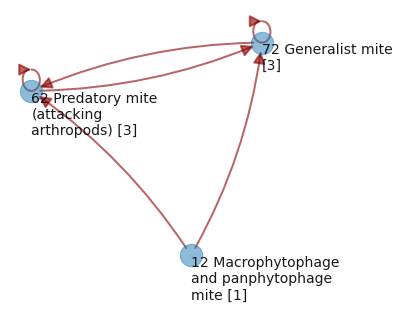

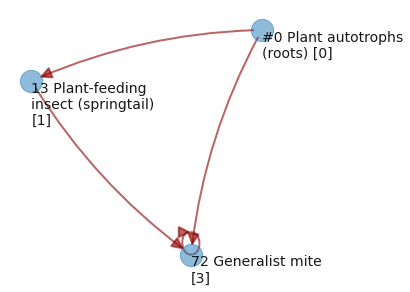

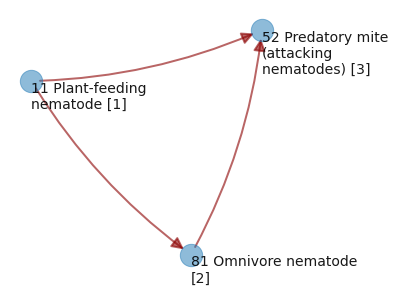

In [73]:
def triangles_edge_iterator_algorithm(g):
    ug = nx.Graph(g)  # make undirected
    adj = ug.adj
    triangles = set()
    for fr,to in ug.edges:
        a_fr = set(adj[fr])
        a_to = set(adj[to])
        for common in a_fr.intersection(a_to):
            vset = {fr, to, common}
            # do not include false positives based on self-loops
            if len(vset) == 3:
                triangles.add(tuple(sorted(vset)))
    return triangles

def is_transitive(g, triangle):
    sg = g.subgraph(triangle)
    # only cyclic triangles are not transitive
    return [x[1] for x in sg.in_degree] != [1,1,1]


def draw_triangles(G, triangles):
    for i,x in enumerate(triangles):
        sg = G.subgraph(x)
        fig, ax = plt.subplots(figsize=(5, 5))
        _ = ax.axis('off')
        pos = nx.spring_layout(sg.to_undirected(), k=10, iterations=1000, seed=123)
        nx.draw_networkx_edges(sg, pos, width=2, alpha=0.6, edge_color="darkred", arrows=True, arrowsize=25, connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_nodes(sg, pos, alpha=0.5, node_size=500)
        _ = nx.draw_networkx_labels(sg, pos, alpha=0.9, font_size=14, clip_on=False, 
                                    labels={node: '\n'.join(textwrap.wrap(f'{node} [{trophic_levels[node]}]', 20, break_long_words=True)) for node in sg.nodes},
                                    horizontalalignment='left',
                                    verticalalignment='top')
        fig.savefig(f'results/figures/transitive_triangles/{i}.png', bbox_inches='tight')
        # plt.close(fig)    

transitive_triangles = [t for t in triangles_edge_iterator_algorithm(G) if is_transitive(G, t)]
print(f'Transitive triangles: {len(transitive_triangles)}')
draw_triangles(G, list(triangles)[:3])

### Strongly connected components

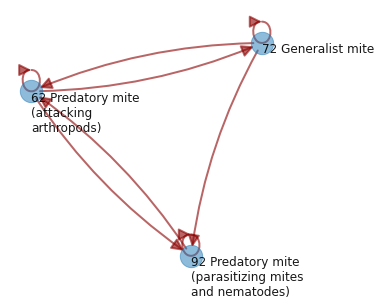

In [17]:
# Discover strongly connected component
import textwrap

strongly_cc = [x for x in list(nx.components.strongly_connected_components(G)) if len(x) > 1]

for i,x in enumerate(strongly_cc):
    sg = G.subgraph(x)
    fig, ax = plt.subplots(figsize=(5, 5))
    _ = ax.axis('off')
    pos = nx.spring_layout(sg.to_undirected(), k=10, iterations=1000, seed=123)
    nx.draw_networkx_edges(sg, pos, width=2, alpha=0.6, edge_color="darkred", arrows=True, arrowsize=25, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_nodes(sg, pos, alpha=0.5, node_size=500)
    _ = nx.draw_networkx_labels(sg, pos, alpha=0.9, font_size=12, clip_on=False, 
                                labels={node: '\n'.join(textwrap.wrap(node, 20, break_long_words=True)) for node in sg.nodes},
                                horizontalalignment='left',
                                verticalalignment='top')
    fig.savefig(f'results/figures/strong_cc_{i}.png', bbox_inches='tight')

### Subgraph discovery (clustering)

In [18]:
# TO-DO: add clustering: by indegree group (0,1,>1), 
#sprehodiš po vseh nodih in daš v tri skupine; dict za kam spadajo, potem pa pobarvat, glede na ključ.

## 4.3 Derived graphs (indirect interactions)

In [19]:
#to-do prepare derived shared predator and prey graphs
# imaš nov graf samo z vozlišči; sprehodiš se po orignalnem grafu po parih vseh vozlišč, in če iamta skupnega predhodnika, potem jih povežeš.

# Others